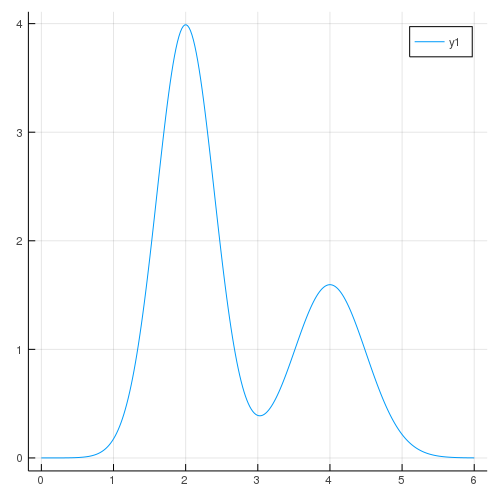

In [1]:
include("../src/StatReg.jl")
using .StatReg
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)
using QuadGK

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

myplot = plot(x, phi.(x))

In [2]:
using QuadGK

kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise;

# plot(y, f, title="Integrated function",label=["f(y)"],seriestype=:scatter, yerr=sig)
# savefig("integrated.png")

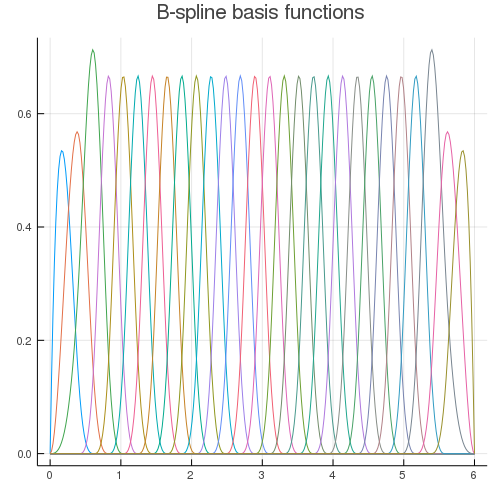

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:101


In [3]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [4]:
kernel_matrix = discretize_kernel(basis, kernel, y)
Omega = omega(basis, 2)
model = MCMCMatrixUnfolder([Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3])
model1 = GaussErrorMatrixUnfolder([Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3]);

┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140
┌ Info: MCMCMatrixUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:56
┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56


In [9]:
prior_phi = zeros(length(basis))
lower_phi = [0 for i in 1:length(basis)]
higher_phi = [1e10 for i in 1:length(basis)]
measure_phi = ones(length(basis)) / 40

@time args = solve(model, kernel_matrix, f, sig, model="Gaussian", nsamples=1_000, nchains=4, sampler="BAT",
    prior_phi=prior_phi, lower_phi=lower_phi, higher_phi=higher_phi, measure_phi=measure_phi);

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:104
┌ Info: Starting find_optimal_alpha...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:17
┌ Info: Starting optimization...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:42
┌ Info: Optimized successfully, alphas = [0.0939681].
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:60
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:119
┌ Info: Starting solve_BAT...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:155
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 4 MCMC chai

  1.392110 seconds (7.61 M allocations: 1.124 GiB, 20.53% gc time)


In [10]:
args1 = solve(model1, kernel_matrix, f, sig)

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Starting find_optimal_alpha...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:17
┌ Info: Starting optimization...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:42
┌ Info: Optimized successfully, alphas = [0.0939681].
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/utils/other_utils.jl:60
┌ Info: Alphas: [0.0939681]
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:97
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.0282709 0.0139413 … 7.80712e-6 4.56869e-6; 0.0139413 0.0623969…
  "alphas" => [0.0939681]
  "coeff"  => [-0.0720358, -0.195247, -0.108074, 0.158079, 0.632708, 1.25348, 1…

In [11]:
# phivec = PhiVec(args["coeff"], basis, cat(args["errors"]...; dims=(1, 2)))

# phi_reconstructed = phivec.phi_function.(x)
# phi_reconstructed_errors = phivec.error_function.(x)

# phivec1 = PhiVec(args1, basis)

# phi_reconstructed1 = phivec1.phi_function.(x)
# phi_reconstructed_errors1 = phivec1.error_function.(x)

# plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="MCMC Reconstructed function with errors")
# plot!(x, phi_reconstructed1, ribbon=phi_reconstructed_errors1, fillalpha=0.3, label="Analytically Reconstructed function with errors")

# plot!(x, phi.(x), label="Real function")
# # savefig("bat.png")

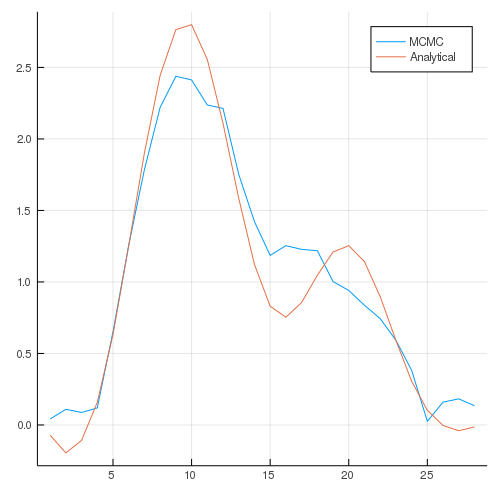

In [12]:
plot(args["coeff"], label="MCMC")
plot!(args1["coeff"], label="Analytical")